In [856]:
import pandas as pd 
from pandas.api.types import CategoricalDtype

import numpy as np 
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [889]:
house_data = pd.read_csv('data/kc_house_data.csv')

test_data = house_data[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
                        'condition','grade', 'yr_built', 'zipcode', 'view', 'price','yr_renovated'
                       ]].copy()

# Drop id nulls and duplicates 
test_data.drop_duplicates(subset= 'id', keep='first', inplace=True, ignore_index = True)


# bedrooms drop all greater than 6
test_data.drop(test_data.index[test_data['bedrooms'] >= 7], inplace = True) # ---- UNDO


#bathrooms remove all bathroom values less than 1 , greater than 4 
# test_data = test_data[test_data.bathrooms >= 1.0]
# test_data = test_data[test_data.bathrooms <= 4.0]
test_data['bathrooms'] = test_data['bathrooms'].dropna()


# sqft_living drop above 5000
# test_data = test_data[test_data.sqft_living < 5000]
# test_data['sqft_living'] = test_data['sqft_living'].map(lambda x: np.log(x)) 




# May potentially reduce range of year built -- cutoff around 1920

# Price drop outliers 
# test_data = test_data[test_data.price < 2000000]
test_data['price'] = test_data['price'].map(lambda x: np.log(x)) # ---- UNDO


# Waterfront drop nulls 
house_data = house_data[house_data['waterfront'].notna()]

# View dropna
test_data = test_data[test_data['view'].notna()]

# grade drop single low value
test_data = test_data[test_data['grade'] != '3 Poor']
# **************************************************************************************
# ABOVE IS GOOD 
test_data.zipcode.value_counts()
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [890]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017439,0.003686,0.007054,-0.011987,-0.133422,0.018239,-0.011643,0.023106,-0.010461,-0.007459,-0.005233,0.019919,-0.001332,-0.138807
price,-0.017439,1.000000,0.309651,0.527350,0.704652,0.087005,0.258277,0.609168,0.053525,0.122590,-0.050212,0.305126,0.021390,0.582167,0.081243
bedrooms,0.003686,0.309651,1.000000,0.516188,0.578211,0.029407,0.182396,0.480593,0.157512,0.017530,-0.151824,-0.010699,0.131640,0.393108,0.027737
bathrooms,0.007054,0.527350,0.516188,1.000000,0.756341,0.085094,0.506214,0.688040,0.507014,0.047328,-0.202160,0.025934,0.223566,0.570061,0.085891
sqft_living,-0.011987,0.704652,0.578211,0.756341,1.000000,0.173345,0.357184,0.877527,0.317443,0.050515,-0.196395,0.053939,0.239177,0.755647,0.182749
sqft_lot,-0.133422,0.087005,0.029407,0.085094,0.173345,1.000000,-0.007246,0.184229,0.055873,0.001981,-0.129722,-0.085789,0.229989,0.146238,0.723061
floors,0.018239,0.258277,0.182396,0.506214,0.357184,-0.007246,1.000000,0.525601,0.490252,-0.000059,-0.058892,0.051345,0.127844,0.280921,-0.010994
sqft_above,-0.011643,0.609168,0.480593,0.688040,0.877527,0.184229,0.525601,1.000000,0.421831,0.019450,-0.258494,0.003035,0.342406,0.733084,0.192293
yr_built,0.023106,0.053525,0.157512,0.507014,0.317443,0.055873,0.490252,0.421831,1.000000,-0.223718,-0.346035,-0.147243,0.409877,0.325704,0.070911
yr_renovated,-0.010461,0.122590,0.017530,0.047328,0.050515,0.001981,-0.000059,0.019450,-0.223718,1.000000,0.068425,0.032325,-0.070709,-0.005146,0.002324


In [891]:
# house_data.yr_renovated.value_counts()

In [892]:
# # ord_cat_selector = ['condition', 'grade', 'view'] # ----original
# ord_cat_selector = ['grade', 'view'] # ----for testing



# cat_subset = test_data[ord_cat_selector]
# cat_subset

# # ordered_condition = ['Poor', 'Fair', 'Average', 'Good', 'Very Good'] #---- for testing
# ordered_grade = ['4 Low', '5 Fair', '6 Low Average', '7 Average','8 Good',
#                  '9 Better', '10 Very Good', '11 Excellent','12 Luxury', 
#                  '13 Mansion']
# ordered_view = ['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT']

# o_enc = OrdinalEncoder(categories = [ordered_grade, ordered_view]) # --- original

# o_enc.fit(cat_subset)

# X_subset = pd.DataFrame(o_enc.transform(cat_subset),
#                         columns = cat_subset.columns)
# # X_subset.shape

In [893]:
# Replace all conditions with floats 0.0 - 1.0

test_data.condition.replace({'Poor':0.2, 'Fair': 0.4, 'Average':0.6, 'Good':0.8, 'Very Good': 1.0}, inplace = True)
# test_data.condition

test_data.grade.replace({'4 Low': 0.1, '5 Fair':0.2, '6 Low Average':0.3, '7 Average':0.4,'8 Good':0.5,
                 '9 Better':0.6, '10 Very Good':0.7, '11 Excellent':0.8,'12 Luxury':0.9, 
                 '13 Mansion':1.0}, inplace = True)

test_data.grade.value_counts()

0.4    8838
0.5    6012
0.6    2589
0.3    1987
0.7    1120
0.8     389
0.2     234
0.9      85
0.1      27
1.0      13
Name: grade, dtype: int64

In [894]:
df = test_data
conditions = [
    np.logical_and(df['yr_built'].ge(1900), pd.Series.lt(df['yr_built'], 1909)),
    np.logical_and(df['yr_built'].ge(1910), pd.Series.lt(df['yr_built'], 1919)),
    np.logical_and(df['yr_built'].ge(1920), pd.Series.lt(df['yr_built'], 1929)),
    np.logical_and(df['yr_built'].ge(1930), pd.Series.lt(df['yr_built'], 1939)),
    np.logical_and(df['yr_built'].ge(1940), pd.Series.lt(df['yr_built'], 1949)),
    np.logical_and(df['yr_built'].ge(1950), pd.Series.lt(df['yr_built'], 1959)),
    np.logical_and(df['yr_built'].ge(1960), pd.Series.lt(df['yr_built'], 1969)),
    np.logical_and(df['yr_built'].ge(1970), pd.Series.lt(df['yr_built'], 1979)),
    np.logical_and(df['yr_built'].ge(1980), pd.Series.lt(df['yr_built'], 1989)),
    np.logical_and(df['yr_built'].ge(1990), pd.Series.lt(df['yr_built'], 1999)),
    np.logical_and(df['yr_built'].ge(2000), pd.Series.lt(df['yr_built'], 2009)),
    np.logical_and(df['yr_built'].ge(2010), pd.Series.lt(df['yr_built'], 2019)),
]

outputs = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

test_data['decadeBuilt'] = pd.Series(np.select(conditions,  outputs))
test_data['decadeBuilt'].value_counts()

In [895]:
# test_data.yr_built.value_counts()

In [896]:
# test_data.corr()

In [897]:
# x = test_data.sqft_living
# # generate data
# y = test_data.grade
# plt.plot(x, y, 'o')
# # create scatter plot

# m, b = np.polyfit(x, y, 1)
# # m = slope, b=intercept

# plt.plot(x, m*x + b)

In [898]:
# x = test_data.price
# # generate data
# y = test_data.grade
# plt.plot(x, y, 'o')
# # create scatter plot

# m, b = np.polyfit(x, y, 1)
# # m = slope, b=intercept

# plt.plot(x, m*x + b)

In [899]:
# x = test_data.price
# # generate data
# y = test_data.sqft_living
# plt.plot(x, y, 'o')
# # create scatter plot

# m, b = np.polyfit(x, y, 1)
# # m = slope, b=intercept

# plt.plot(x, m*x + b)

In [900]:
formula1 = 'price ~ grade'
model = ols(formula=formula1, data= test_data).fit()
# model.summary()

In [901]:
# test_data['sqft_living'] = test_data['sqft_living'].map(lambda x: np.log(x)) 


# outcome = test_data.condition
# x_cols = [test_data.yr_built]
# predictors = '+'.join(x_cols)
# formula = 'grade ~ price + condition + yr_built' # --- r2 = 0.650 ---- w/0 condition = 0.649
formula = 'grade ~ price + yr_built + sqft_living + bedrooms+ floors'
model = ols(formula=formula, data= test_data).fit()
# model.summary()

In [902]:
# formula = 'price ~ grade + yr_built + sqft_living + bedrooms+ floors + condition' # -- 0.629
formula = 'price ~ grade + sqft_living + bathrooms + floors + yr_built + zipcode'


model = ols(formula=formula, data= test_data).fit()
# model.summary()

In [903]:
# ord_cat_selector = ['condition', 'grade', 'view'] # ----original
ord_cat_selector = ['view'] # ----for testing



cat_subset = test_data[ord_cat_selector]
cat_subset

# ordered_condition = ['Poor', 'Fair', 'Average', 'Good', 'Very Good'] #---- for testing
ordered_grade = ['4 Low', '5 Fair', '6 Low Average', '7 Average','8 Good',
                 '9 Better', '10 Very Good', '11 Excellent','12 Luxury', 
                 '13 Mansion']
ordered_view = ['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT']

o_enc = OrdinalEncoder(categories = [ordered_view]) # --- original

o_enc.fit(cat_subset)

X_subset = pd.DataFrame(o_enc.transform(cat_subset),
                        columns = cat_subset.columns)
X_subset.shape

(21294, 1)

In [904]:
# # should remove yr_built
#original predictor ---- R Score =  0.854
# nom_features = ['grade', 'bathrooms', 'sqft_living', 'floors', 'yr_built', 'price', 'condition', 'lat'] #original
# nom_features = ['bathrooms', 'sqft_living', 'price'] # ---TEST



# dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
# dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)

# X_p = pd.concat([test_data[nom_features], X_subset,  dum_year, dum_zipcode],join = 'inner', axis = 1) 


# X = X_p.drop(columns = 'price')
# y = X_p['price']

# X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3, random_state = 1)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
nom_features = ['bathrooms', 'sqft_living', 'price'] # ---TEST



dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)

X_p = pd.concat([test_data[nom_features], dum_zipcode],join = 'inner', axis = 1) 


X = X_p.drop(columns = 'price')
y = X_p['price']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3, random_state = 1)

In [905]:
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p = lr_p.predict(X_test_p)
R_p = lr_p.score(X_train_p, y_train_p)
MAE_p = mean_absolute_error(y_pred_p, y_test_p)
RMSE_p = np.sqrt(mean_squared_error(y_pred_p, y_test_p))
print('R Score = ', R_p, '\n' 'MAE = ', MAE_p, '\n' 'RMSE = ', RMSE_p, '\n' 'First five predicted values : ', y_pred_p[0:5])

R Score =  0.8256178712629211 
MAE =  0.1591132164647351 
RMSE =  0.21696062078984246 
First five predicted values :  [12.36677964 12.63138331 13.17471689 13.19713302 12.08035436]


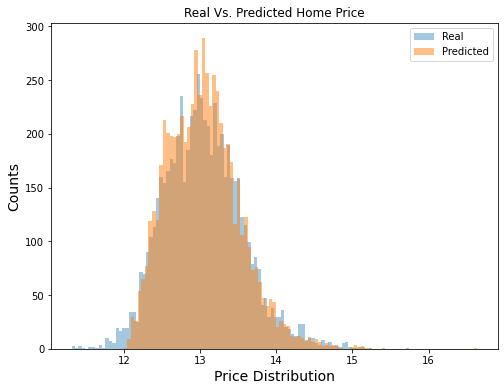

In [906]:
plt.figure(figsize=(8,6))
plt.hist(y_test_p, bins=100, alpha=0.4, label="Real")
plt.hist(y_pred_p, bins=100, alpha=0.5, label="Predicted")
plt.xlabel("Price Distribution", size=14)
plt.ylabel("Counts", size=14)
plt.title("Real Vs. Predicted Home Price")
plt.legend(loc='upper right');

In [961]:
X2 = sm.add_constant(X)
_1  = sm.OLS(y, X2)
_2  = _1.fit()

# print(_2.summary())

In [908]:
y_pred_p = pd.Series(y_pred_p, name = 'p_price')
type(y_pred_p)
len(y_pred_p)
type(X_)

y_pred_p

0       12.366780
1       12.631383
2       13.174717
3       13.197133
4       12.080354
          ...    
6384    12.770843
6385    13.603394
6386    12.430433
6387    13.170119
6388    13.073601
Name: p_price, Length: 6389, dtype: float64

In [909]:
# #should remove yr_built
nom_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                 'grade'] #test--- R Score =  0.731


dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)

X_ = pd.concat([test_data[nom_features],y_pred_p, X_subset, dum_year, dum_zipcode],
               join = 'inner', axis = 1) #-- original --- Good

# X_ = pd.concat([test_data[nom_features], X_subset, dum_year, dum_zipcode],
#                join = 'inner', axis = 1) #-- test

# X_.drop(df.index[:1], inplace=True)
# X_ = pd.concat(X_, y_pred_p, join = 'inner', axis = 1
# # TEST
               
X = X_.drop(columns = 'grade')
y = X_['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# print(X.head(), X_.head(), y_pred_p)
# print(X_.bathrooms)
# print(X.head(),y_pred_p, test_data[nom_features].loc[6346:6350, :])
# print(X_.columns)
# print(X_[['p_price', 'price']])

In [911]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# R = lr.score(X_train, y_train)
# MAE = mean_absolute_error(y_pred, y_test)
# RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
# y_pred = lr.predict(X_test)
# COEF = lr.coef_
# print('R Score = ', R, '\n' 'MAE = ', MAE, '\n' 'RMSE = ', RMSE, 
#       '\n' 'First five predicted values : ', y_pred[0:5], '\n', COEF)

In [913]:
# y_test.value_counts()
# len(y_test) #ten unique 0-1 -len 1894
# y_test.value_counts()

In [914]:
y_pred= pd.Series(y_pred, name = 'p_grade')
# y_pred.value_counts() #problem is that theyre all unique - y_test has 10 unique - len 1894

In [915]:
# plt.figure(figsize=(8,6))
# plt.hist(y_test, bins=100, alpha=0.2, label="Real")
# plt.hist(y_pred, bins=100, alpha=0.5, label="Predicted")
# plt.xlabel("Data", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Predicted Vs. Actual")
# plt.legend(loc='upper right');

# plt.figure(figsize=(8,6))
# plt.hist(np.exp(y_test), bins=100, alpha=0.5, label="Real")
# plt.hist(np.exp(y_pred), bins=100, alpha=0.2, label="Predicted")
# plt.xlabel("Data", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Predicted Vs. Actual")
# plt.legend(loc='upper right');

# **** Below is good 


# plt.figure(figsize=(8,6))
# plt.hist(y_test, bins=100, alpha=0.2, label="Real")
# plt.hist(np.round(y_pred, decimals = 1), bins=100, alpha=0.5, label="Predicted")
# plt.xlabel("Data", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Predicted Vs. Actual")
# plt.legend(loc='upper right');

# plt.figure(figsize=(8,6))
# plt.hist(np.exp(y_test), bins=100, alpha=0.5, label="Real")
# plt.hist(np.exp(y_pred), bins=100, alpha=0.2, label="Predicted")
# plt.xlabel("Data", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Predicted Vs. Actual")
# plt.legend(loc='upper right');

/Users/austinboring/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms', ylabel='price'>

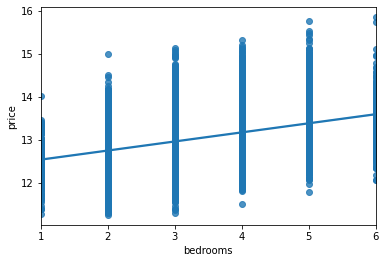

In [916]:
x_vari = np.array(range(len(y_test)))

# plt.scatter(x_vari, y_test, s = 0.5, c='coral')
# m, b = np.polyfit(x_vari, y_test, 1)
# plt.plot(x_vari, m*x_vari + b)

# plt.scatter(x_vari, y_pred, s = 0.5, c='lightblue')

# plt.title('Actual Vs. Predicted')
# plt.xlabel('Count')
# plt.ylabel('Price')
# plt.show()

# plt.scatter(y_test, y_pred, s = 1, c='lightblue')

# plt.title('Actual Vs. Predicted')
# plt.xlabel('Count')
# plt.ylabel('Price')
# plt.show()

sns.regplot(test_data.bedrooms,test_data.price, fit_reg = True)

/Users/austinboring/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

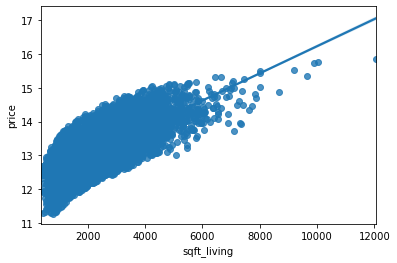

In [950]:
# sns.regplot(test_data.bedrooms,test_data.price, fit_reg = True)
sns.regplot(test_data.sqft_living,test_data.price, fit_reg = True)
# sns.regplot(test_data['yr_built'].loc[test_data.yr_built > 2000],
#             test_data['price'].loc[test_data.yr_built > 2000], fit_reg = True)

/Users/austinboring/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='yr_built', ylabel='price'>

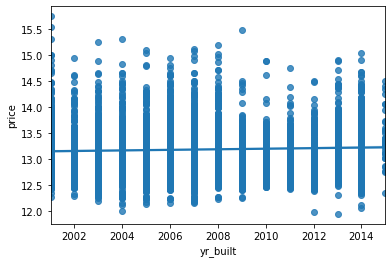

In [948]:
sns.regplot(test_data['yr_built'].loc[test_data.yr_built > 2000],test_data['price'].loc[test_data.yr_built > 2000], fit_reg = True)

In [943]:
df = test_data
conditions = [
    np.logical_and(df['yr_renovated'].ge(1900), pd.Series.lt(df['yr_renovated'], 1909)),
    np.logical_and(df['yr_renovated'].ge(1910), pd.Series.lt(df['yr_renovated'], 1919)),
    np.logical_and(df['yr_renovated'].ge(1920), pd.Series.lt(df['yr_renovated'], 1929)),
    np.logical_and(df['yr_renovated'].ge(1930), pd.Series.lt(df['yr_renovated'], 1939)),
    np.logical_and(df['yr_renovated'].ge(1940), pd.Series.lt(df['yr_renovated'], 1949)),
    np.logical_and(df['yr_renovated'].ge(1950), pd.Series.lt(df['yr_renovated'], 1959)),
    np.logical_and(df['yr_renovated'].ge(1960), pd.Series.lt(df['yr_renovated'], 1969)),
    np.logical_and(df['yr_renovated'].ge(1970), pd.Series.lt(df['yr_renovated'], 1979)),
    np.logical_and(df['yr_renovated'].ge(1980), pd.Series.lt(df['yr_renovated'], 1989)),
    np.logical_and(df['yr_renovated'].ge(1990), pd.Series.lt(df['yr_renovated'], 1999)),
    np.logical_and(df['yr_renovated'].ge(2000), pd.Series.lt(df['yr_renovated'], 2009)),
    np.logical_and(df['yr_renovated'].ge(2010), pd.Series.lt(df['yr_renovated'], 2019)),
]

outputs = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

test_data['decadeRen'] = pd.Series(np.select(conditions,  outputs))
# test_data['decadeRen'] = test_data[test_data.decadeRen > 0]
test_data['decadeRen'].value_counts()
# test_data['decadeRen'].columns
test_data.loc[test_data['yr_built'] > 2000]
# test_data.yr_renovated.value_counts()

,id,bedrooms,bathrooms,sqft_living,floors,condition,grade,yr_built,zipcode,view,price,yr_renovated,decadeRen
5,7237550310,4,4.50,5420,1.0,0.6,0.8,2001,98053,NONE,14.022525,0.0,0.0
9,3793500160,3,2.50,1890,2.0,0.6,0.4,2003,98038,NONE,12.685408,0.0,0.0
29,1873100390,4,2.50,2570,2.0,0.6,0.5,2005,98052,NONE,13.485617,0.0,0.0
30,8562750320,3,2.50,2320,2.0,0.6,0.5,2003,98027,NONE,13.271645,0.0,0.0
31,2426039314,2,1.50,1190,3.0,0.6,0.4,2005,98133,NONE,12.542545,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,263000018,3,2.50,1530,3.0,0.6,0.5,2009,98103,NONE,12.793859,0.0,NaN
21416,6600060120,4,2.50,2310,2.0,0.6,0.5,2014,98146,NONE,12.899220,0.0,NaN
21417,1523300141,2,0.75,1020,2.0,0.6,0.4,2009,98144,NONE,12.904459,0.0,NaN
21418,291310100,3,2.50,1600,2.0,0.6,0.5,2004,98027,NONE,12.899220,0.0,NaN


In [717]:

# # Grade Good *******************


# nom_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built',
#                  'price', 'grade'] #original
# ord_features = X_subset
# # dum_waterfront = pd.get_dummies(house_data['waterfront'], prefix = 'wtr', drop_first = True)
# # X_ = pd.concat([test_data[nom_features], X_subset, dum_waterfront],join = 'inner', axis = 1) #-- original
# X_ = pd.concat([test_data[nom_features], X_subset],join = 'inner', axis = 1) #--original
# X_ = test_data[nom_features] #--test


# X = X_.drop(columns = 'grade')
# y = X_['grade']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [718]:
X_.shape

(6312, 192)

In [719]:
X_.corr()

,bedrooms,bathrooms,sqft_living,floors,grade,price,0,view,year_1901,year_1902,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
bedrooms,1.000000,0.519957,0.570377,0.230667,0.367452,0.344636,0.000336,-0.009893,-0.020100,0.015097,...,-0.019939,-0.019134,-0.001292,-0.003650,-0.029924,0.008306,-0.009417,-0.006999,-0.032361,-0.031950
bathrooms,0.519957,1.000000,0.761720,0.500400,0.669779,0.554163,-0.010473,-0.001364,-0.031138,0.023014,...,-0.050462,-0.027272,-0.047993,-0.014148,-0.096684,0.007283,-0.054348,-0.033182,-0.059617,0.003989
sqft_living,0.570377,0.761720,1.000000,0.397384,0.762369,0.688101,-0.010353,-0.000168,-0.022071,0.011996,...,-0.047585,-0.033817,-0.039300,0.008556,-0.075430,0.041030,-0.042901,-0.027897,-0.059450,0.004135
floors,0.230667,0.500400,0.397384,1.000000,0.466322,0.337365,-0.011589,-0.004491,0.004581,0.044408,...,-0.050269,-0.037074,-0.067207,-0.045977,-0.055267,-0.039620,-0.056331,-0.037860,-0.065458,-0.021727
grade,0.367452,0.669779,0.762369,0.466322,1.000000,0.692280,-0.002503,-0.001176,-0.022451,-0.000361,...,-0.065219,-0.027976,-0.044477,-0.014013,-0.100526,0.031725,-0.073260,-0.052870,-0.066562,0.022631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip_98177,0.008306,0.007283,0.041030,-0.039620,0.031725,0.055471,-0.009786,0.004575,-0.003800,-0.004249,...,-0.011775,-0.005704,-0.016297,-0.012462,-0.012085,1.000000,-0.011931,-0.009531,-0.013114,-0.012755
zip_98178,-0.009417,-0.054348,-0.042901,-0.056331,-0.073260,-0.100880,-0.000424,-0.006944,-0.003985,-0.004456,...,-0.012349,-0.005982,-0.017091,-0.013069,-0.012673,-0.011931,1.000000,-0.009995,-0.013753,-0.013377
zip_98188,-0.006999,-0.033182,-0.027897,-0.037860,-0.052870,-0.092553,-0.002682,0.000507,-0.003183,-0.003560,...,-0.009865,-0.004779,-0.013653,-0.010440,-0.010124,-0.009531,-0.009995,1.000000,-0.010987,-0.010686
zip_98198,-0.032361,-0.059617,-0.059450,-0.065458,-0.066562,-0.141634,-0.006150,-0.002758,-0.004380,-0.004898,...,-0.013574,-0.006575,-0.018787,-0.014365,-0.013931,-0.013114,-0.013753,-0.010987,1.000000,-0.014704


In [560]:
lr = LinearRegression()
lr.fit(X_train, y_train)
R = lr.score(X_train, y_train)
MAE = mean_absolute_error(y_pred, y_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
y_pred = lr.predict(X_test)
print('R Score = ', R, '\n' 'MAE = ', MAE, '\n' 'RMSE = ', RMSE, '\n' 'First ten predicted values : ', y_pred[0:10])



R Score =  0.8313035595668021 
MAE =  540822.7142246345 
RMSE =  625004.402482344 
First ten predicted values :  [12.87623024 13.6283493  12.90746307 12.34732437 13.18253899 13.06458664
 13.39937019 13.24502945 13.29973984 13.50205612]


In [493]:
diff = (((np.abs(np.exp(y_pred) - np.exp(y_test))) / np.exp(y_test)) * 100).mean()
diff

16.413921035633262

In [561]:
diff = ((np.abs(y_pred - y_test) / y_test) * 100).mean()
diff

1.224421848587491

In [567]:
X_test.index

Int64Index([ 7868, 16333, 13352, 20348, 16893,  4865, 14134, 11029, 11032,
            11037,
            ...
            18110, 19776,  6461, 13406, 18634,  1323,  5717, 19281, 15129,
            20535],
           dtype='int64', length=6351)

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

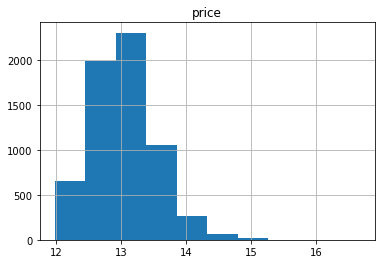

In [563]:
# predicted_home_price = pd.DataFrame(np.exp(y_pred),columns = ['price'])
# predicted_home_price.loc[predicted_home_price['price'] < 5000000].hist()

predicted_home_price = pd.DataFrame(y_pred,columns = ['price'])
predicted_home_price.loc[predicted_home_price['price'] < 2750000].hist()
# predicted_home_price.hist()

<AxesSubplot:>

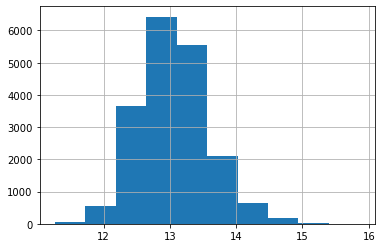

In [565]:
# sns.histplot(house_data.price)
actual_home_price = (np.log(house_data.price))
actual_home_price.loc[actual_home_price < 2750000].hist()
# actual_home_price.hist()

In [432]:
# lr.score(X_train, y_train)

In [431]:
# lr.get_params()

In [423]:
# This gets the predictions of model on test set.
y_pred = lr.predict(X_test)
y_pred[0:10]
#get first ten elements of prediction.
y_pred[0:10]

# # This gets the predictions of model on test set.
# y_pred = lr.predict(np.exp(X_test))
# #get first ten elements of prediction.
# y_pred[0:10]

array([13.43056481, 12.94901106, 13.14090708, 12.14852883, 13.79016748,
       13.62518569, 13.77284823, 12.82499276, 13.12262279, 13.01958009])

In [424]:
MAE = mean_absolute_error(y_pred, y_test)
MAE

0.14798104591009428

In [425]:
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
RMSE

0.20565865318031412

In [386]:
np.exp

<ufunc 'exp'>

In [962]:
test_data.grade.value_counts()

0.4    8838
0.5    6012
0.6    2589
0.3    1987
0.7    1120
0.8     389
0.2     234
0.9      85
0.1      27
1.0      13
Name: grade, dtype: int64

/Users/austinboring/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


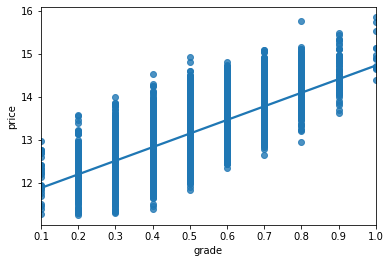

In [960]:
# sns.regplot(test_data.bedrooms,test_data.price, fit_reg = True)
# sns.regplot(test_data.sqft_living,test_data.price, fit_reg = True)
# sns.regplot(test_data['yr_built'].loc[test_data.yr_built > 2000],
#             test_data['price'].loc[test_data.yr_built > 2000], fit_reg = True)
sns.regplot(test_data.grade, test_data.price, fit_reg = True);

# sns.regplot(yr_o_2000, pr_o_2000, fit_reg = True)

In [952]:
yr_o_2000 = test_data['yr_built'].loc[test_data.yr_built > 2000]
pr_o_2000 = test_data['price'].loc[test_data.yr_built > 2000]

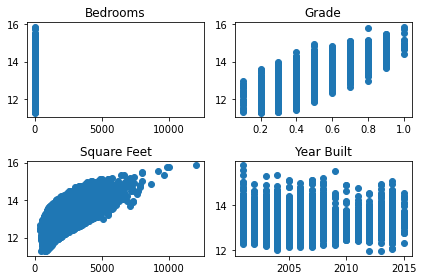

In [958]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(test_data.bedrooms, test_data.price)
axs[0, 0].set_title("Bedrooms")
axs[1, 0].scatter(test_data.sqft_living, test_data.price)
axs[1, 0].set_title("Square Feet")
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].scatter(test_data.grade, test_data.price)
axs[0, 1].set_title("Grade")
axs[1, 1].scatter(yr_o_2000, pr_o_2000)
axs[1, 1].set_title("Year Built")
fig.tight_layout()